<a href="https://colab.research.google.com/github/alethat/MachineLearningTasks/blob/main/Midterm%20Task/MidtermTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [ ]:
# Install PyTorch and Hugging Face Transformers library
!pip install torch torchvision torchaudio
!pip install transformers

# Load a pre-trained BERT model

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

# Prepare Input Data

In [ ]:
import pandas as pd
from google.colab import files

uploaded = files.upload()
df = pd.read_csv("spam.csv")
df.head()

Saving spam.csv to spam.csv


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.columns = ['label', 'text']

# Encode labels (spam=1, ham=0)
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

# Check for missing values
print(df.isnull().sum())

label    0
text     0
dtype: int64


#  BERT for sequence classification

In [ ]:
# Tokenisasi data teks
inputs = tokenizer(df['text'].tolist(), padding=True, truncation=True, return_tensors="pt")
labels = torch.tensor(df['label'].values)  # Mengubah label menjadi tensor

In [ ]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(df['text'], df['label'], test_size=0.2)

# Pastikan data input berupa list dari string
train_texts = train_texts.tolist()
test_texts = test_texts.tolist()

# Tokenisasi dataset training dan test
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512, return_tensors="pt")

# Mengubah label menjadi tensor
train_labels = torch.tensor(train_labels.values)
test_labels = torch.tensor(test_labels.values)

In [ ]:
# Pastikan model berada di GPU jika tersedia
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Pindahkan tensor input ke perangkat yang sama (GPU atau CPU)
test_encodings = {key: val.to(device) for key, val in test_encodings.items()}

# Melakukan prediksi pada data test
with torch.no_grad():
    outputs = model(**test_encodings)

# Mengambil hasil prediksi (logits) dan menentukan label prediksi
predicted_labels = torch.argmax(outputs.logits, dim=-1)

# Menampilkan hasil prediksi
print(predicted_labels)

tensor([1, 1, 1,  ..., 1, 1, 1], device='cuda:0')


# Fine-tune the BERT model for custom sequence analysis

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class SpamDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
train_dataset = SpamDataset(train_texts, train_labels)
test_dataset = SpamDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
10,0.827800
20,0.789800
30,0.680000
40,0.531800
50,0.423400
60,0.382500
70,0.274100
80,0.138800
90,0.153300
100,0.112400


TrainOutput(global_step=837, training_loss=0.07893123379933538, metrics={'train_runtime': 575.7757, 'train_samples_per_second': 23.223, 'train_steps_per_second': 1.454, 'total_flos': 879514480304640.0, 'train_loss': 0.07893123379933538, 'epoch': 3.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.041409753262996674,
 'eval_runtime': 7.9945,
 'eval_samples_per_second': 139.471,
 'eval_steps_per_second': 8.756,
 'epoch': 3.0}

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

# Create a DataFrame to display metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Score': [accuracy, precision, recall, f1]
})

# Display the table

metrics_df

,Metric,Score
0,Accuracy,0.993722
1,Precision,0.993743
2,Recall,0.993722
3,F1-score,0.993731


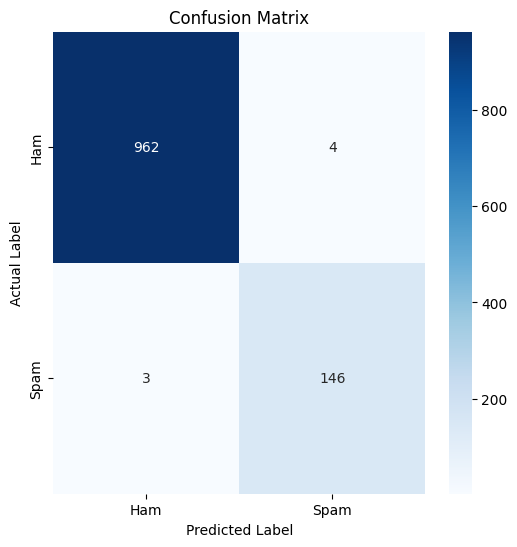

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import random


# Ambil sejumlah contoh secara acak
num_examples = 15 # misalnya kita ingin melihat 5 contoh
example_indices = random.sample(range(len(test_labels)), num_examples)

# Tampilkan contoh prediksi beserta label aslinya
for idx in example_indices:
    print(f"Example {idx}:")
    print(f"  Actual Label: {test_labels[idx]}")
    print(f"  Predicted Label: {predicted_labels[idx]}")
    print()

Example 51:
  Actual Label: 1
  Predicted Label: 1

Example 563:
  Actual Label: 1
  Predicted Label: 1

Example 501:
  Actual Label: 0
  Predicted Label: 0

Example 457:
  Actual Label: 0
  Predicted Label: 0

Example 285:
  Actual Label: 0
  Predicted Label: 0

Example 209:
  Actual Label: 0
  Predicted Label: 0

Example 178:
  Actual Label: 0
  Predicted Label: 0

Example 864:
  Actual Label: 0
  Predicted Label: 0

Example 65:
  Actual Label: 0
  Predicted Label: 0

Example 61:
  Actual Label: 0
  Predicted Label: 0

Example 191:
  Actual Label: 0
  Predicted Label: 0

Example 447:
  Actual Label: 0
  Predicted Label: 0

Example 476:
  Actual Label: 0
  Predicted Label: 0

Example 1034:
  Actual Label: 0
  Predicted Label: 0

Example 54:
  Actual Label: 0
  Predicted Label: 0



# Optimize BERT's performance

In [ ]:
from transformers import get_linear_schedule_with_warmup
from torch.optim import AdamW

# Buat optimizer AdamW
optimizer = AdamW(model.parameters(), lr=2e-5)

# Tentukan jumlah langkah training total
batch_size = training_args.per_device_train_batch_size
total_training_steps = (len(train_dataset) // batch_size) * training_args.num_train_epochs

# Buat scheduler dengan linear warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=500, num_training_steps=total_training_steps
)

trainer_optimizer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    optimizers=(optimizer, scheduler)
)

In [ ]:
trainer_optimizer.train()

Step,Training Loss
10,0.000200
20,0.000100
30,0.000100
40,0.000100
50,0.000700
60,0.000100
70,0.000100
80,0.000100
90,0.000100
100,0.000100


TrainOutput(global_step=837, training_loss=0.005627022994308189, metrics={'train_runtime': 327.7472, 'train_samples_per_second': 40.797, 'train_steps_per_second': 2.554, 'total_flos': 879514480304640.0, 'train_loss': 0.005627022994308189, 'epoch': 3.0})

In [ ]:
trainer_optimizer.evaluate()

{'eval_loss': 0.0569375678896904,
 'eval_runtime': 7.9272,
 'eval_samples_per_second': 140.656,
 'eval_steps_per_second': 8.83,
 'epoch': 3.0}

In [ ]:
# Make predictions on the test set
predictions = trainer_optimizer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=1)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

# Create a DataFrame to display metrics
metrics_optim_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Score': [accuracy, precision, recall, f1]
})

# Display the table

metrics_optim_df

,Metric,Score
0,Accuracy,0.991928
1,Precision,0.991909
2,Recall,0.991928
3,F1-score,0.991917


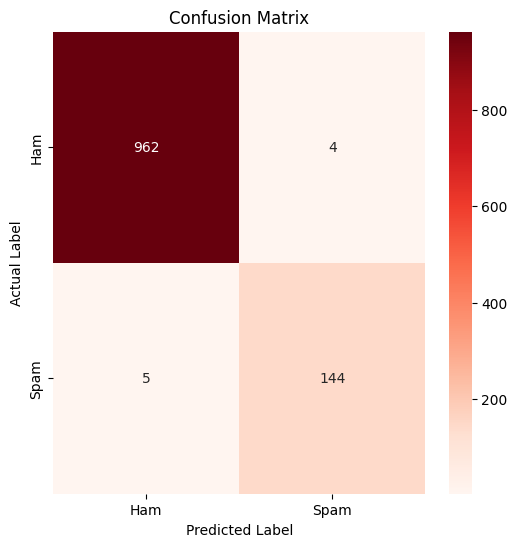

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Membuat confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Menampilkan confusion matrix menggunakan heatmap
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import random

# Ambil sejumlah contoh secara acak
num_examples = 15
example_indices = random.sample(range(len(test_labels)), num_examples)

# Tampilkan contoh prediksi beserta label aslinya
for idx in example_indices:
    print(f"Example {idx}:")
    print(f"  Actual Label: {test_labels[idx]}")
    print(f"  Predicted Label: {predicted_labels[idx]}")
    print()

Example 228:
  Actual Label: 0
  Predicted Label: 0

Example 51:
  Actual Label: 1
  Predicted Label: 1

Example 563:
  Actual Label: 1
  Predicted Label: 1

Example 501:
  Actual Label: 0
  Predicted Label: 0

Example 457:
  Actual Label: 0
  Predicted Label: 0

Example 285:
  Actual Label: 0
  Predicted Label: 0

Example 209:
  Actual Label: 0
  Predicted Label: 0

Example 178:
  Actual Label: 0
  Predicted Label: 0

Example 864:
  Actual Label: 0
  Predicted Label: 0

Example 65:
  Actual Label: 0
  Predicted Label: 0

Example 61:
  Actual Label: 0
  Predicted Label: 0

Example 191:
  Actual Label: 0
  Predicted Label: 0

Example 447:
  Actual Label: 0
  Predicted Label: 0

Example 476:
  Actual Label: 0
  Predicted Label: 0

Example 1034:
  Actual Label: 0
  Predicted Label: 0

